In [1]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
def group_data(data, window_size=96):
    """
    Separa o vetor data em pares de vetores X de entrada e valor de predição y
    data: Conjunto de dados
    window_size: Tamanho dos vetores de dados em X
    Retorna o vetor X e Y
    """
    data_X = []
    data_Y = []
    len_data = len(data)
    for i in range(len_data - window_size):
        data_X.append(data[i:i + window_size])
        data_Y.append(data[i + window_size])
    return np.array(data_X), np.array(data_Y)

In [9]:
import pandas as pd
import numpy as np
import importlib

from segmentation_algorithms.utils import *

from time import perf_counter 

try:
  importlib.reload(plot)
except:
  import plot
  importlib.reload(plot)
from plot import plot

try:
  importlib.reload(segmentation_algorithms.topdown_index)
except:
  import segmentation_algorithms.topdown_index
  importlib.reload(segmentation_algorithms.topdown_index)
from segmentation_algorithms.topdown_index import XTSTreeTopDownIndex

try:
  importlib.reload(segmentation_algorithms.topdown_reg)
except:
  import segmentation_algorithms.topdown_reg
  importlib.reload(segmentation_algorithms.topdown_reg)
from segmentation_algorithms.topdown_reg import XTSTreeTopDownReg

try:
  importlib.reload(XTSTree.XTSTreePageHinkley)
except:
  import XTSTree.XTSTreePageHinkley
  importlib.reload(XTSTree.XTSTreePageHinkley)
from XTSTree.XTSTreePageHinkley import XTSTreePageHinkley

In [3]:
series = np.array(pd.read_csv('./datasets/base datasets/23025122/export_automaticas_23025122_tempmedar2m.csv')['tempmedar2m'][:96*20])

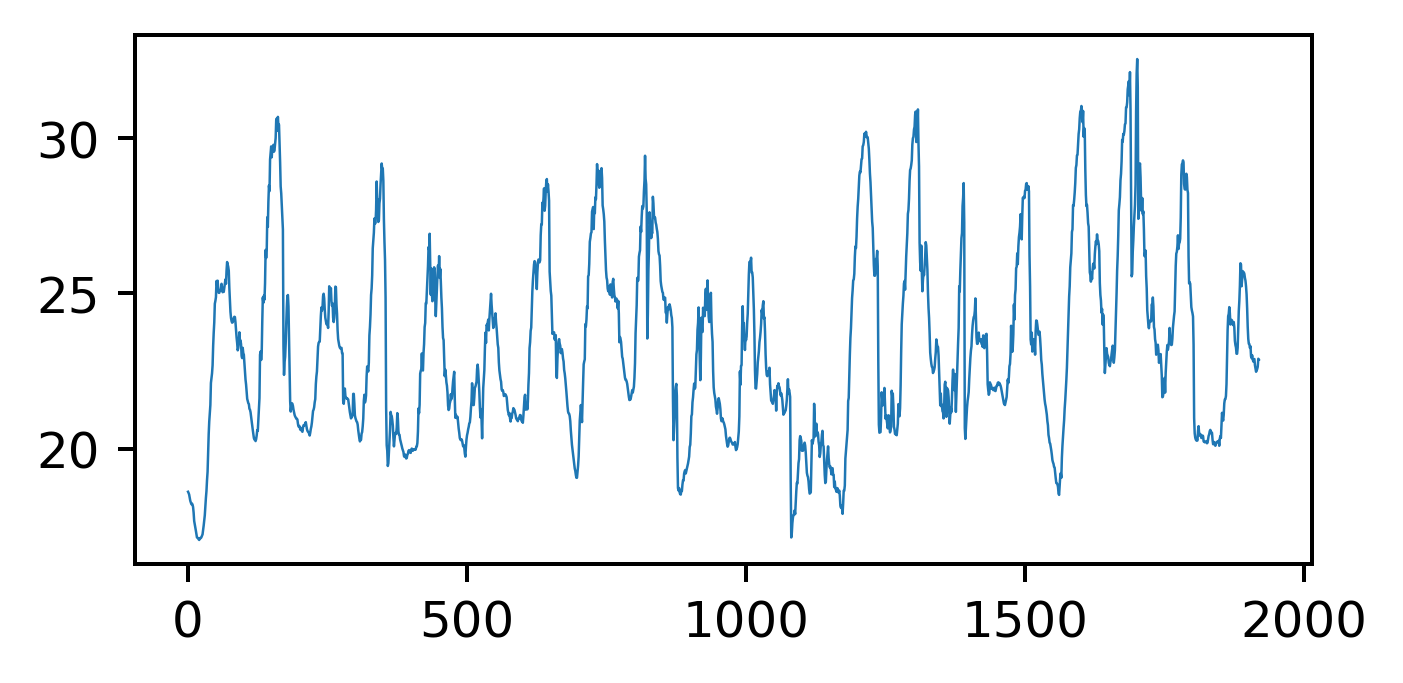

In [4]:
plot(series)

Não achei só um corte, escolhendo corte que gera maior pontuação, 1634, 683.5525588636692, 0, 5


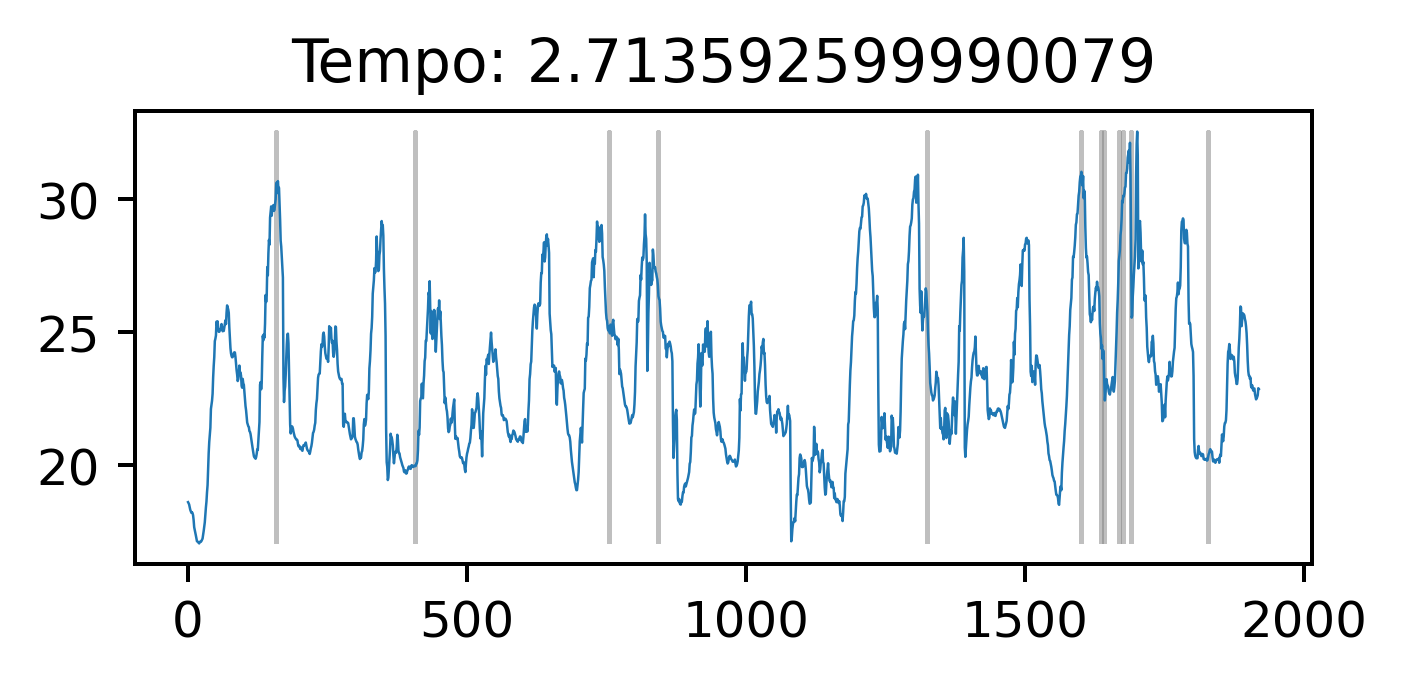

In [5]:
t = perf_counter()
ph_model = XTSTreePageHinkley(stop_condition='adf', stop_val=0.5, max_iter=100, min_dist=0)
ph_model = ph_model.create_splits(series)
plot(np.array(series), divisions=ph_model.cut_points(), title=f'Tempo: {perf_counter() - t}')

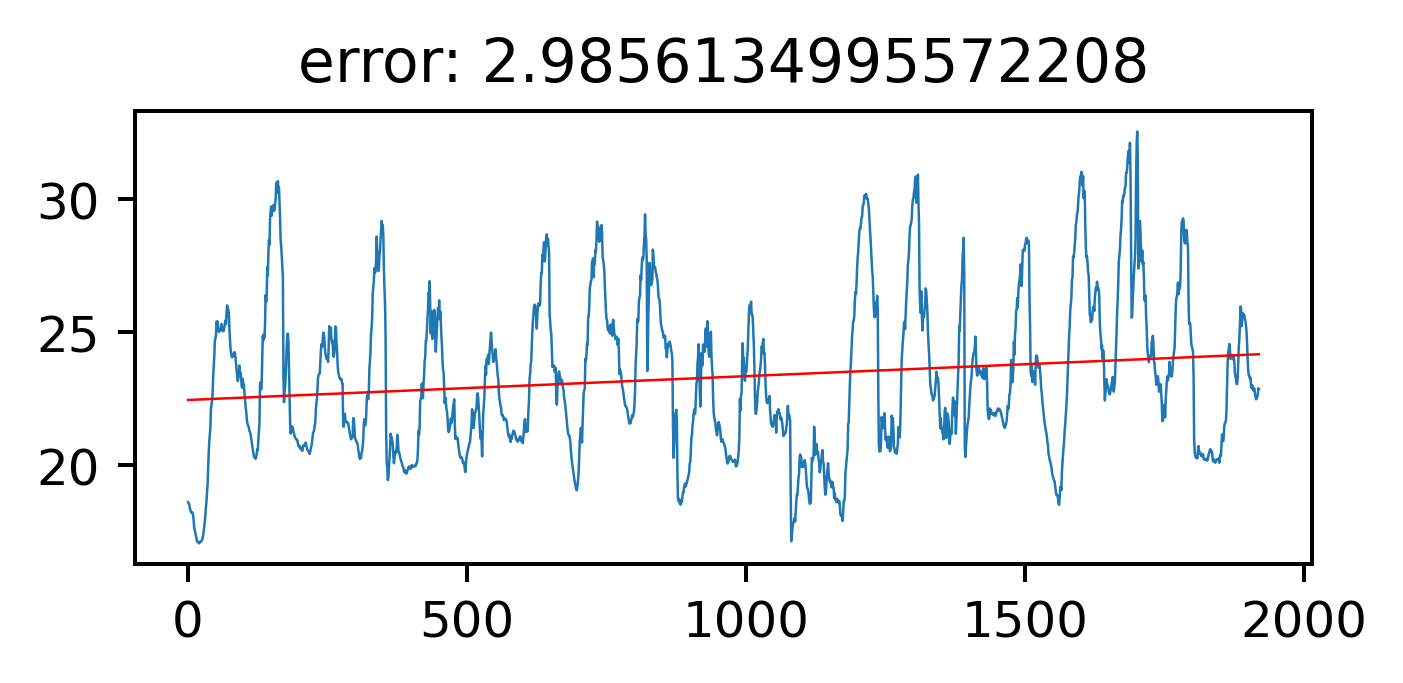

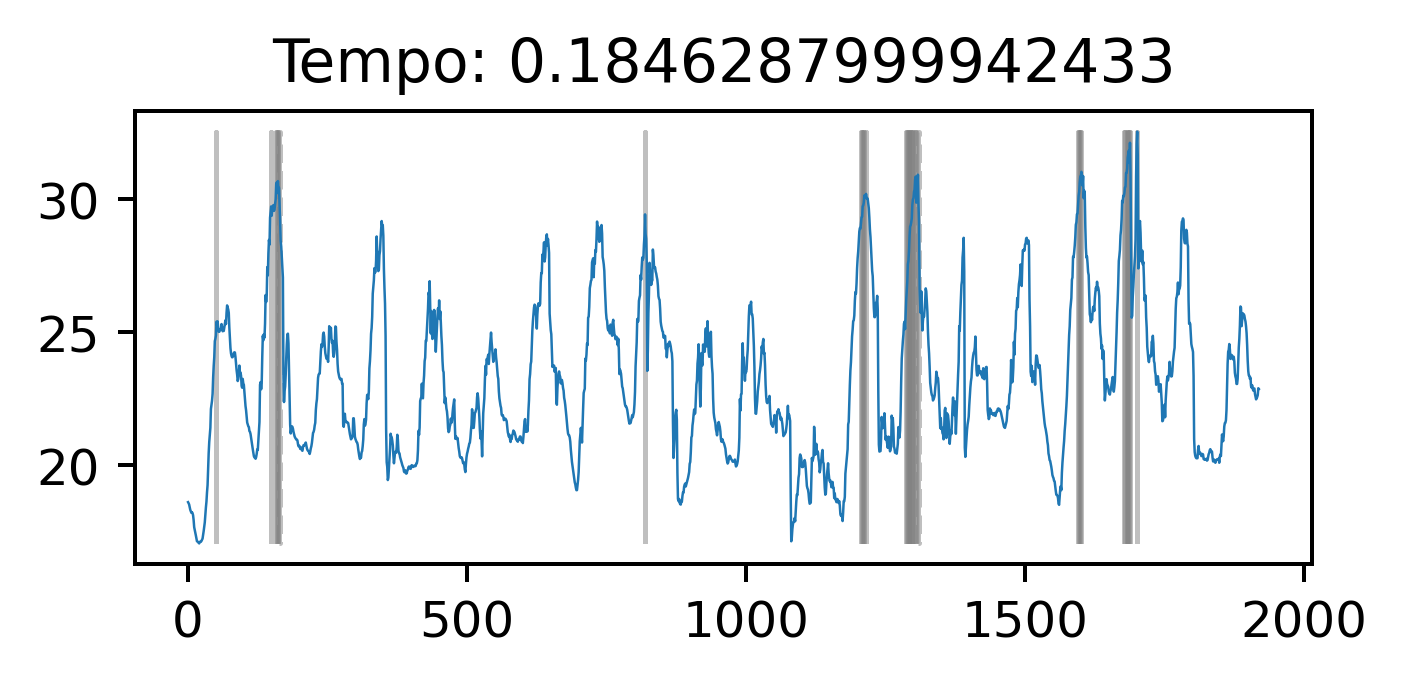

In [24]:
m_model, _, _, _ = apply_lr(np.arange(len(series)), series)
yhat = m_model.predict(np.arange(len(series)).reshape(-1, 1))
error = rmse(series, yhat)
plot(series, sec_plots=[yhat], title=f'error: {error}')

t = perf_counter()
tdi_model = XTSTreeTopDownIndex(stop_val=2.5, max_iter=100, min_dist=0)
tdi_model = tdi_model.create_splits(series)
plot(series, divisions=tdi_model.cut_points(), title=f'Tempo: {perf_counter() - t}')

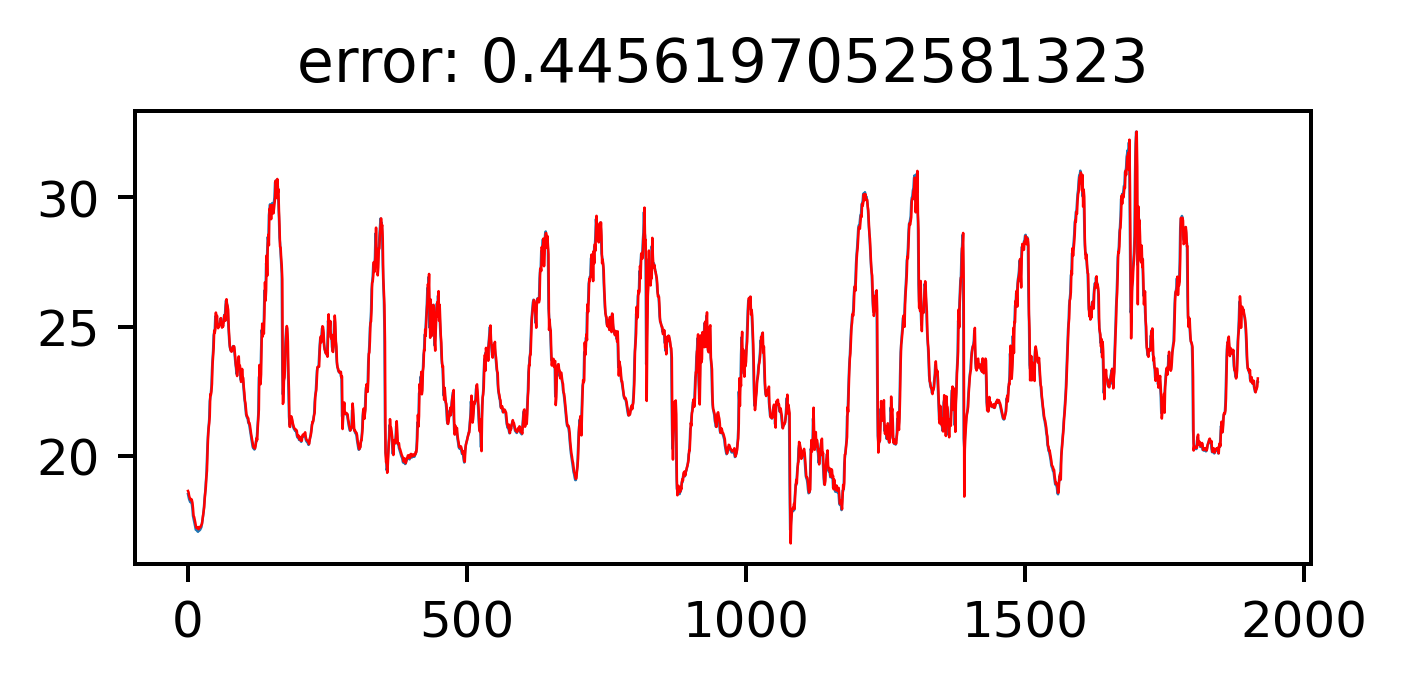

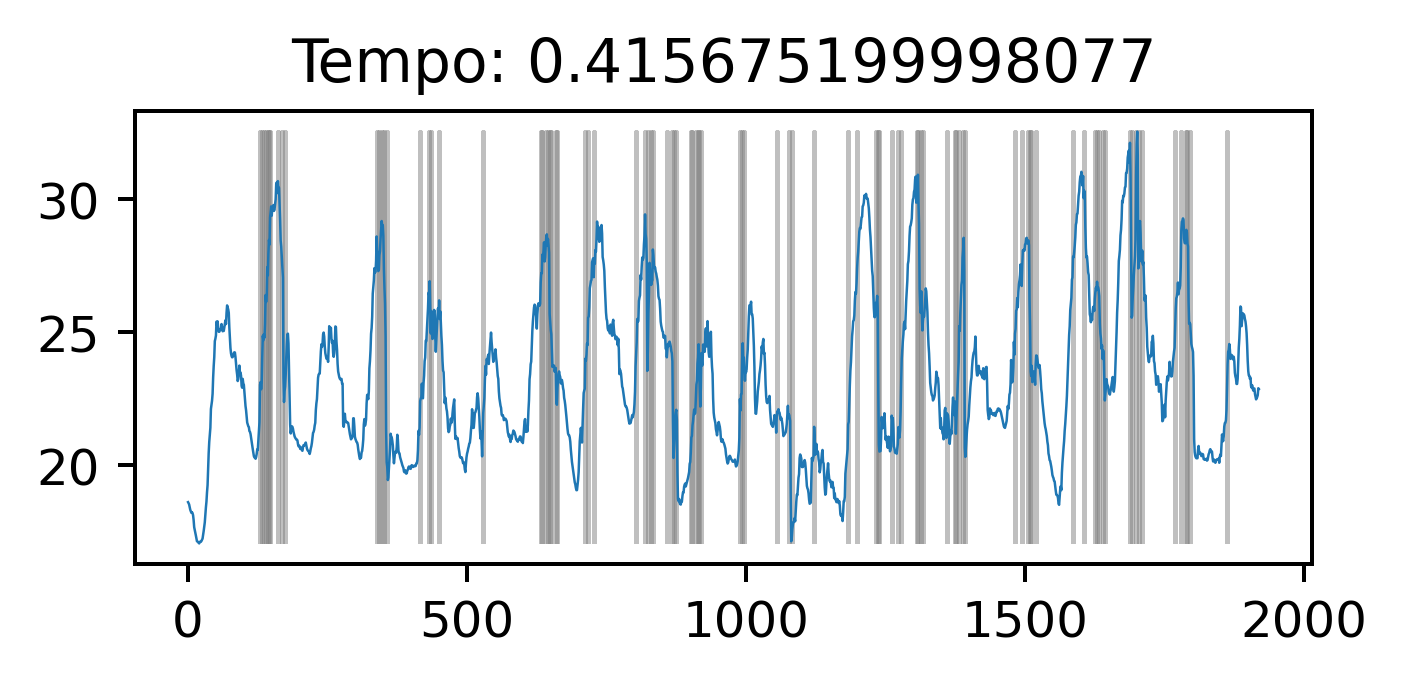

In [30]:
lag = 2

X, y = group_data(series, lag)
m_model, _, _, _ = apply_lr(X, y)
yhat = m_model.predict(X)
error = rmse(series[lag:], yhat)
plot(series[lag:], sec_plots=[yhat], title=f'error: {error}')

t = perf_counter()
tdr_model = XTSTreeTopDownReg(stop_val=0.3, max_iter=100, min_dist=0, lag=lag)
tdr_model = tdr_model.create_splits(series)
plot(series, divisions=tdr_model.cut_points(), title=f'Tempo: {perf_counter() - t}')

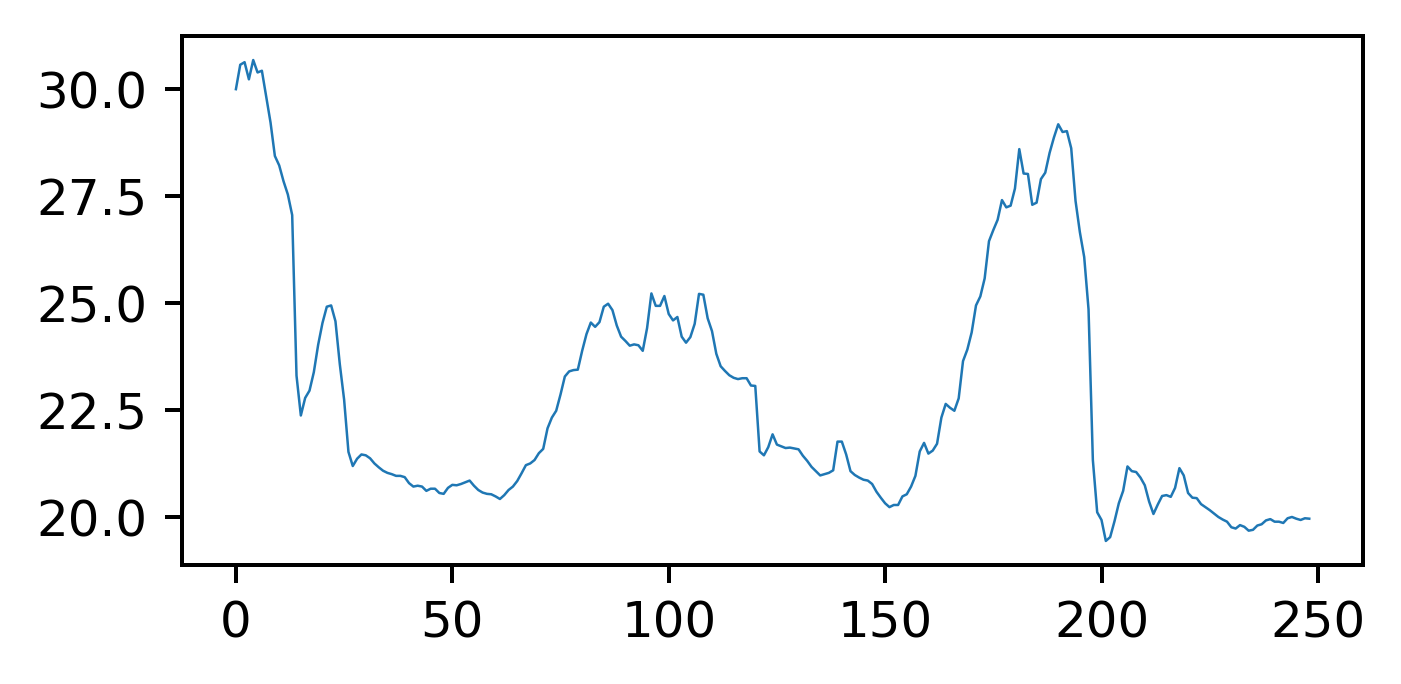

In [26]:
plot(ph_model.cut_series(series)[1])

In [27]:
from pysr import *

In [28]:
from pysr import *
def get_regressor(
    criteria,
    output_file,
    pop_n,
    pop_size,
    iterations,
    path,
    max_complexity=20,
    binary_operators=['+', '-', '*', '/', 'pow'],
    unary_operators=['sqrt', 'sin'],
    constraints=None,
    verbosity = 0,
   ):
  """
  constraints é um dicionário com os operadores unários e binários e uma tupla com a complexidade máxima dos argumentos.
  ver o que o should_simplify faz, aparentemente simplifica a equação, mas ver como ele faz isso
  usar random_state pra garantir mesmos resultados
  """
  return PySRRegressor(
    binary_operators=['+', '-', '*', '/', 'pow'],
    unary_operators=['sqrt', 'sin'],
    maxsize=max_complexity,
    niterations=iterations,
    populations=pop_n,
    population_size=pop_size,
    progress=False,
    model_selection=criteria,
    equation_file=f'./symbreg_objects/{output_file}.csv',
    verbosity = 0,
    temp_equation_file=False
  )

In [ ]:
modelo = get_regressor(
  criteria='score',
  output_file='teste',
  pop_n=5,
  pop_size=20,
  iterations=20,
  path='./',
  max_complexity=18,
)
